In [1]:
import copy
import os
import warnings

import torch
from dotenv import load_dotenv
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from tqdm.auto import tqdm

load_dotenv("../env")

warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [2]:
from luminar.document.data import (
    FeatureDataset,
    PaddingDataloader,
    n_way_split,
)
from luminar.document.model import ConvolutionalLayerSpec, DocumentClassficationModel
from luminar.features import FeatureExtractor, OneDimFeatures, Slicer, TwoDimFeatures
from luminar.mongo import MongoPipelineDataset

In [3]:
config = {
    "seed": 1337,
    "eval_split": 0.1,
    "test_split": 0.1,
    # "feature_model": "gpt2",
    "feature_model": "meta-llama/Llama-3.2-1B",
}

In [4]:
sources = [
    "ieee-chatgpt-generation.jsonl",
    "ieee-chatgpt-polish.jsonl",
    "ieee-chatgpt-fusion.jsonl",
    # "ieee-init.jsonl",
]

In [5]:
datasets = {}
for source in tqdm(sources):
    dataset = MongoPipelineDataset(
        mongo_db_connection=os.environ.get("MONGO_DB_CONNECTION"),
        database="prismai",
        collection="features_CHEAT",
        pipeline=[
            {
                "$lookup": {
                    "from": "dataset_CHEAT",
                    "as": "document.source",
                    "localField": "document._id.$id",
                    "foreignField": "_id",
                }
            },
            {
                "$unwind": "$document.source",
            },
            {
                "$match": {
                    # "document.source.source": source,
                    "document.source.source": {"$in": ["ieee-init.jsonl", source]},
                }
            },
            {
                "$group": {
                    "_id": "$document.source.id",
                    "features": {
                        "$push": {
                            "label": "$document.label",
                            "source": "$document.source.source",
                            "type": "$document.type",
                            "split": "$split",
                            "transition_scores": "$transition_scores",
                        }
                    },
                }
            },
        ],
    ).load()
    datasets[source] = dataset

  0%|          | 0/3 [00:00<?, ?it/s]

[MongoPipelineDataset] Loading Documents from MongoDB: 0it [00:00, ?it/s]

[MongoPipelineDataset] Writing Cache File /nvme/.cache/luminar/97ea3707c420acfb660be595429e3076beb11aef5101a61f2792f18b7f3595a5.pkl


[MongoPipelineDataset] Loading Documents from MongoDB: 0it [00:00, ?it/s]

[MongoPipelineDataset] Writing Cache File /nvme/.cache/luminar/7dcafc7afd73568978a04f52e505d1bf15d45e89d0f776c51fc59fc7ea4d1ff0.pkl


[MongoPipelineDataset] Loading Documents from MongoDB: 0it [00:00, ?it/s]

[MongoPipelineDataset] Writing Cache File /nvme/.cache/luminar/5bdf271ea22922bac2ed3ac86b526c386452f9841323bc2819f61e1b85ef011d.pkl


In [6]:
train_splits = {}
eval_splits = {}
test_splits = {}
for ai_counterpart, dataset in datasets.items():
    seed_everything(config["seed"])
    train_dataset, eval_dataset, test_dataset = n_way_split(
        dataset,
        config["eval_split"],
        config["test_split"],
        infer_first=True,
    )
    train_splits[ai_counterpart] = train_dataset
    eval_splits[ai_counterpart] = eval_dataset
    test_splits[ai_counterpart] = test_dataset

Seed set to 1337
Seed set to 1337
Seed set to 1337


In [27]:
# feature_dim = OneDimFeatures(128)
# featurizer = FeatureExtractor.Likelihood()
# config["second_dim_as_channels"] = False
feature_dim = TwoDimFeatures(256, 13)
# featurizer = FeatureExtractor.LikelihoodTopkLikelihoodRatio(13)
featurizer = FeatureExtractor.IntermediateLogits(13)
config["second_dim_as_channels"] = True

slicer = Slicer.First(feature_dim[0])
# slicer = Slicer.Random(feature_dim[0])
# slicer = Slicer.RandomMultiple(feature_dim[0] // 4, multiple=4, stride=16)
# slicer = Slicer.RandomMultiple(feature_dim[0] // 4, 4)

config["feature_dim"] = feature_dim
config["featurizer"] = repr(featurizer)
config["slicer"] = repr(slicer)

config["num_samples"] = None


def featurize(dataset) -> FeatureDataset:
    return FeatureDataset(
        tqdm(dataset, desc="Featurizing", leave=False),
        slicer,
        featurizer,
        num_samples=config["num_samples"],
        label_field="label",
        label_zero="human",
    )

In [28]:
train_datasets, eval_datasets, test_datasets = {}, {}, {}
for ai_counterpart, dataset in tqdm(datasets.items()):
    train_datasets[ai_counterpart] = featurize(train_splits[ai_counterpart])
    eval_datasets[ai_counterpart] = featurize(eval_splits[ai_counterpart])
    test_datasets[ai_counterpart] = featurize(test_splits[ai_counterpart])

  0%|          | 0/3 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/12317 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/12317 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/12317 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

## In-Domain Training & Evaluation

In [29]:
config |= {
    "projection_dim": None,
    "learning_rate": 0.0002,
    "warmup_steps": 150,
    "max_epochs": 50,
    "gradient_clip_val": 1.0,
    "batch_size": 128,
}

# SeqXGPT Layer Configuration
config["conv_layer_shapes"] = [
    ConvolutionalLayerSpec(64, 5),
    *[ConvolutionalLayerSpec(128, 3)] * 3,
    ConvolutionalLayerSpec(64, 3),
]

In [30]:
from torch.utils.data import ConcatDataset


# capturing config from "closure"
def get_dataloader(*dataset, **kwargs) -> PaddingDataloader:
    if len(dataset) == 1:
        dataset = dataset[0]
    else:
        dataset = ConcatDataset(dataset)
    return PaddingDataloader(
        dataset,
        feature_dim=config["feature_dim"],
        batch_size=config["batch_size"],
        **kwargs,
    )

In [31]:
results_in_domain = {}
for ai_counterpart in sources:
    seed_everything(config["seed"])

    train_dataloader = get_dataloader(train_datasets[ai_counterpart], shuffle=True)
    eval_dataloader = get_dataloader(eval_datasets[ai_counterpart])

    model = DocumentClassficationModel(**config)
    trainer = Trainer(
        max_epochs=config["max_epochs"],
        logger=pl_loggers.TensorBoardLogger(
            save_dir=f"logs/CHEAT/{type(featurizer).__name__}",
        ),
        gradient_clip_val=config["gradient_clip_val"],
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
        deterministic=True,
    )

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=eval_dataloader,
    )

    trainer.progress_bar_callback.disable()
    metrics = []
    for other, dataset in test_datasets.items():
        trainer.validate(
            model, get_dataloader(eval_datasets[other]), verbose=False
        )
        metrics.append(
            {
                "other": other,
            }
            | trainer.test(
                model,
                get_dataloader(dataset),
                verbose=False,
            )[0]
        )
    trainer.progress_bar_callback.enable()

    results_in_domain[ai_counterpart] = {
        "domain": ai_counterpart,
        "config": copy.deepcopy(config),
        "metrics": metrics,
    }
    print(ai_counterpart, metrics)


Seed set to 1337
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 152 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?          
--------------------------------------------------------------------------------------
168 K     Trainable params
0         Non-trainable params
168 K     Total params
0.674     Total estimated model params size (MB)
15        Modules in train mode
0         Module

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
import pandas as pd

results = []
for ai_counterpart in sources:
    results.append(
        [
            results_in_domain[ai_counterpart]["metrics"][i]["test_roc_auc"]
            for i in range(len(sources))
        ]
    )

df = pd.DataFrame(results, columns=sources, index=sources)
df

,ieee-chatgpt-generation.jsonl,ieee-chatgpt-polish.jsonl,ieee-chatgpt-fusion.jsonl
ieee-chatgpt-generation.jsonl,0.964502,0.661757,0.555440
ieee-chatgpt-polish.jsonl,0.858091,0.745134,0.557497
ieee-chatgpt-fusion.jsonl,0.684514,0.576405,0.556985


## Cross-Domain Training & Evaluation

In [ ]:
seed_everything(config["seed"])
train_dataloader = get_dataloader(*train_datasets.values(), shuffle=True)
eval_dataloader = get_dataloader(*eval_datasets.values())
test_dataloader = get_dataloader(*test_datasets.values())

model = DocumentClassficationModel(**config)
trainer = Trainer(
    max_epochs=config["max_epochs"],
    logger=pl_loggers.TensorBoardLogger(
        save_dir=f"logs/all_domains/{type(featurizer).__name__}",
    ),
    gradient_clip_val=config["gradient_clip_val"],
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
    deterministic=True,
)
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=eval_dataloader,
)

Seed set to 1337
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes   | Out sizes 
------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 152 K  | train | ?          | ?         
1 | projection  | Identity          | 0      | train | [32, 8192] | [32, 8192]
2 | classifier  | Linear            | 8.2 K  | train | [32, 8192] | [32, 1]   
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?          | ?         
------------------------------------------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.progress_bar_callback.disable()
metrics_cross_domain = []
for other, dataset in test_datasets.items():
    trainer.validate(model, get_dataloader(eval_datasets[ai_counterpart]), verbose=False)
    metrics_cross_domain.append(
        {"other": other}
        | trainer.test(
            model,
            get_dataloader(dataset),
            verbose=False,
        )[0]
    )
trainer.validate(model, eval_dataloader, verbose=False)
metrics_cross_domain += [
    {
        "other": "ALL",
        **trainer.test(
            model,
            test_dataloader,
            verbose=False,
        )[0],
    }
]
trainer.progress_bar_callback.enable()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
import pandas as pd


def df_to_latex_heatmap(_df: pd.DataFrame):
    print(
        "\\plotHeatmap{"
        + ",".join(_df.index)
        + "}{%\n    "
        + ",%\n    ".join(
            [
                "{"
                + ",".join(f"{val:.4f}/{round(val, 2):.2f}" for val in row[1:])
                + "}"
                for row in _df.reset_index().values
            ]
        )
        + "%\n}{"
        + ",".join(_df.columns)
        + "}"
    )


In [ ]:
_metric = "test_roc_auc"
# _metric = "test_acc@best"

results = []
for ai_counterpart in sources:
    results.append(
        [
            results_in_domain[ai_counterpart]["metrics"][i][_metric]
            for i in range(len(sources))
        ]
    )
results.append([m[_metric] for m in metrics_cross_domain[:len(sources)]])

df = pd.DataFrame(results, columns=sources, index=list(sources) + ["ALL"])
df["AVG"] = df.mean(axis=1)
df["AVG"][-1] = metrics_cross_domain[-1][_metric]
df

/tmp/ipykernel_320943/1923075231.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["AVG"][-1] = metrics_cross_domain[-1][_metric]
/tmp/ipykernel_320943/1923075231.py:16: FutureWarning: Series.__setitem__ treating keys as positions is d

,ieee-chatgpt-generation.jsonl,ieee-chatgpt-polish.jsonl,ieee-chatgpt-fusion.jsonl,AVG
ieee-chatgpt-generation.jsonl,0.964502,0.661757,0.555440,0.727233
ieee-chatgpt-polish.jsonl,0.858091,0.745134,0.557497,0.720241
ieee-chatgpt-fusion.jsonl,0.684514,0.576405,0.556985,0.605968
ALL,0.954187,0.764417,0.588544,0.825239


In [ ]:
df_to_latex_heatmap(df)

\plotHeatmap{ieee-chatgpt-generation.jsonl,ieee-chatgpt-polish.jsonl,ieee-chatgpt-fusion.jsonl,ALL}{%
    {0.9645/0.96,0.6618/0.66,0.5554/0.56,0.7272/0.73},%
    {0.8581/0.86,0.7451/0.75,0.5575/0.56,0.7202/0.72},%
    {0.6845/0.68,0.5764/0.58,0.5570/0.56,0.6060/0.61},%
    {0.9542/0.95,0.7644/0.76,0.5885/0.59,0.8252/0.83}%
}{ieee-chatgpt-generation.jsonl,ieee-chatgpt-polish.jsonl,ieee-chatgpt-fusion.jsonl,AVG}


In [ ]:
config

{'seed': 1337,
 'eval_split': 0.1,
 'test_split': 0.1,
 'feature_model': 'meta-llama/Llama-3.2-1B',
 'second_dim_as_channels': True,
 'feature_dim': TwoDimFeatures(height=128, width=13),
 'featurizer': 'IntermediateLogits(last_n=13)',
 'slicer': 'SliceRandomMultiple(size=32, multiple=4, stride=16, sort=False)',
 'num_samples': None,
 'projection_dim': None,
 'learning_rate': 0.0002,
 'warmup_steps': 150,
 'max_epochs': 50,
 'gradient_clip_val': 1.0,
 'batch_size': 128,
 'conv_layer_shapes': [(64, 5, 1),
  (128, 3, 1),
  (128, 3, 1),
  (128, 3, 1),
  (64, 3, 1)]}

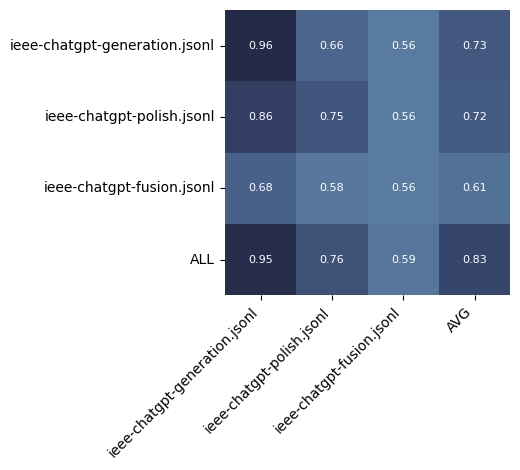

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    vmax=1.0,
    vmin=0.0,
    cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True),
    yticklabels=list(sources) + ["ALL"],
    xticklabels=list(sources) + ["AVG"],
    square=True,
    # reduce annotation font size
    annot_kws={"fontsize": 8},
    cbar=False,
)

# rotate x-axis labels by 45 degrees
# anchored at the right edge of the axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

plt.tight_layout()
# plt.savefig(
#     "../figures/evaluation-trained_in_domain-test_0.1-gpt2_256-rand_4-il_13_as_channels.pdf",
#     dpi=300,
# )
plt.show()

### LLR on Whole Datasets

In [ ]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores
from simple_dataset import Dataset as SimpleDataset
from transition_scores.data import TransitionScores

results_llr = []
for ai_counterpart, split in datasets.items():
    dataset_test = (
        SimpleDataset(split)
        .flat_map(lambda doc: doc["features"])
        .map(
            lambda x: {
                "llr": llr_from_transition_scores(
                    TransitionScores(**x["transition_scores"])
                ),
                "labels": int(x["label"] != "human"),
            },
            in_place=False,
        )
    )
    fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
    auroc = auc(fpr, tpr)

    preds = np.array(dataset_test["llr"])
    labels = np.array(dataset_test["labels"])

    mean_0 = float(np.mean(preds[labels == 0]))
    mean_1 = float(np.mean(preds[labels == 1]))

    thresholds = np.linspace(round(mean_0, 1) - 0.2, round(mean_1, 1) + 0.3, 5001)
    preds_thresholded: np.ndarray = preds > thresholds.reshape(-1, 1)
    acc_thresholded = np.mean((preds_thresholded == labels), axis=1)
    idx = np.argmax(acc_thresholded)
    best_threshold = thresholds[idx]
    best_acc = acc_thresholded[idx]

    results_llr.append({
        "domain": ai_counterpart,
        "auroc": auroc,
        "best_acc": best_acc,
        "best_threshold": best_threshold,
    })

pd.DataFrame(results_llr)

ImportError: cannot import name 'TransitionScores' from 'transition_scores.data' (/nvme/projects/PrismAI/PrismAI/src/transition_scores/data.py)

### LLR on Test Splits

In [ ]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores
from simple_dataset import Dataset as SimpleDataset
from transition_scores.data import TransitionScores

results_llr = []
for ai_counterpart, split in test_splits.items():
    dataset_test = (
        SimpleDataset(split)
        .flat_map(lambda doc: doc["features"])
        .map(
            lambda x: {
                "llr": llr_from_transition_scores(
                    TransitionScores(**x["transition_scores"])
                ),
                "labels": int(x["label"] != "human"),
            },
            in_place=False,
        )
    )
    fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
    auroc = auc(fpr, tpr)

    preds = np.array(dataset_test["llr"])
    labels = np.array(dataset_test["labels"])

    mean_0 = float(np.mean(preds[labels == 0]))
    mean_1 = float(np.mean(preds[labels == 1]))

    thresholds = np.linspace(round(mean_0, 1) - 0.2, round(mean_1, 1) + 0.3, 1001)
    preds_thresholded: np.ndarray = preds > thresholds.reshape(-1, 1)
    acc_thresholded = np.mean((preds_thresholded == labels), axis=1)
    idx = np.argmax(acc_thresholded)
    best_threshold = thresholds[idx]
    best_acc = acc_thresholded[idx]

    results_llr.append({
        "domain": ai_counterpart,
        "auroc": auroc,
        "best_acc": best_acc,
        "best_threshold": best_threshold,
    })

pd.DataFrame(results_llr)

In [ ]:
raise RuntimeError("STOP")

In [ ]:
sample = train_dataset[0]["features"].numpy().squeeze()
train_dataset[0]["labels"]

In [ ]:
fig = plt.imshow(sample.T, cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True))
fig.axes.set_axis_off()
plt.show()

In [ ]:
sample = train_dataset[2]["features"].numpy().squeeze()
train_dataset[2]["labels"]

In [ ]:
fig = plt.imshow(sample.T, cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True))
fig.axes.set_axis_off()
plt.show()

In [ ]:
raise RuntimeError("STOP")

In [ ]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores

dataset_test = dm._dataset_test.map(
    lambda x: {
        "llr": llr_from_transition_scores(x["features"]),
        "labels": x["labels"],
    },
    in_place=False,
)
fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
auc(fpr, tpr)